In [359]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import numpy as np

In [371]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [406]:
df = pd.read_csv('train_data_updated_v6.csv', parse_dates=['datetime'])

#бинарная переменная, которая показывает наличие аварии
df['bin_target'] = df.target.apply(lambda x: 1 if x != 0 else 0)

In [407]:
#статистика аварий по километрам трасс
crash_stat = df.groupby(['road_id', 'road_km']).agg({'bin_target': 'sum'})\
  .sort_values(by='bin_target', ascending=False)\
  .reset_index()

In [410]:
crash_stat[crash_stat['bin_target'] > 50].sort_values(by=['road_id', 'bin_target'], ascending=False).reset_index().head(40)

,index,road_id,road_km,bin_target
0,26,14,1378,184
1,27,14,12,173
2,32,14,13,129
3,41,14,16,88
4,52,14,21,73
5,56,14,66,69
6,57,14,1386,68
7,58,14,17,67
8,61,14,19,66
9,63,14,22,64


In [409]:
#количество аварий, в которых известна информация от трафике
stat_traffic = df.dropna(subset = ['lane_count_f'])\
                  .groupby(['road_id', 'road_km']).agg({'bin_target': 'sum'})\
                  .sort_values(by='bin_target', ascending=False)\
                  .reset_index()

stat_traffic.sort_values(by=[ 'bin_target'], ascending=False).reset_index().head(30)

,index,road_id,road_km,bin_target
0,0,9,23,228
1,1,9,22,217
2,2,9,254,126
3,3,9,38,71
4,4,14,16,43
5,5,9,274,35
6,6,9,17,33
7,7,9,181,26
8,8,9,57,23
9,9,14,108,22


Иромация о трафике есть только на четырех участках с количестом аварий больше 50, можем убрать трафик из данных

<AxesSubplot:>

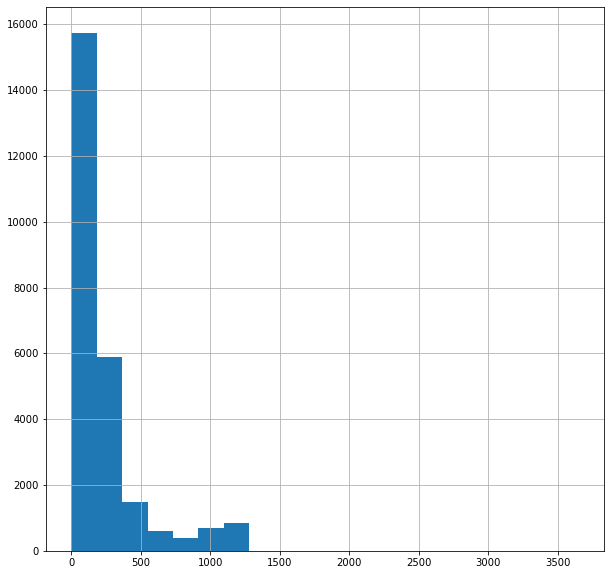

In [375]:
plt.figure(figsize=(10, 10))
df[(df.target > 0) & (df.road_id == 9)].road_km.hist(bins=20)

In [376]:
drop_cols_1 = ['volume_1', 'volume_2',
       'volume_3', 'volume_4', 'volume_5', 'volume_6', 'volume_7', 'volume_8',
       'volume_9', 'volume_10', 'volume_11', 'volume_12', 'occupancy_1',
       'occupancy_2', 'occupancy_3', 'occupancy_4', 'occupancy_5',
       'occupancy_6', 'occupancy_7', 'occupancy_8', 'occupancy_9',
       'occupancy_10', 'occupancy_11', 'occupancy_12', 'speed_1', 'speed_2',
       'speed_3', 'speed_4', 'speed_5', 'speed_6', 'speed_7', 'speed_8',
       'speed_9', 'speed_10', 'speed_11', 'speed_12', 'lane_count_f',
       'lane_count_b', 'mean_volume_b', 'mean_volume_f', 'std_volume_b',
       'std_volume_f', 'mean_occupancy_b', 'mean_occupancy_f',
       'std_occupancy_b', 'std_occupancy_f', 'mean_speed_b', 'mean_speed_f',
       'std_speed_b', 'std_speed_f']


In [377]:
dropped_df = df.drop(drop_cols_1, axis=1)
dropped_df.head(2)

,datetime,road_id,road_km,target,year,repair,avuch_loc,stabchar_type,cnt_subs,lat_long,station,date,phenomenon,intensity,start_datetime,end_datetime,hour,weekday,year_season,bin_target
0,2018-01-01 01:00:00,9,730,1.0,2018,0.0,NaN,NaN,NaN,"(61.13, 42.12)",VELSK,2018-01-01,снег мокрый,слабая интенсивность,2018-01-01 00:00:00,2018-01-01 01:23:00,1,0,1,1
1,2018-01-01 04:00:00,9,57,1.0,2018,0.0,NaN,NaN,NaN,"(56.18, 38.03)",MOSKVDN,2018-01-01,дымка,слабая интенсивность,2018-01-01 03:00:00,2018-01-01 05:30:00,4,0,1,1


In [378]:
dropped_df.avuch_loc =  dropped_df.avuch_loc.fillna(0)
dropped_df.stabchar_type  = dropped_df.stabchar_type.fillna(0)
dropped_df.cnt_subs = dropped_df.cnt_subs.fillna(0)

In [379]:
drop_cols_2 = ['lat_long', 'station', 'date', 'start_datetime', 'end_datetime']

In [380]:
dropped_df = dropped_df.drop(drop_cols_2, axis=1)

In [381]:
dropped_df[dropped_df.bin_target > 0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34035 entries, 0 to 34034
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   datetime       34035 non-null  datetime64[ns]
 1   road_id        34035 non-null  int64         
 2   road_km        34035 non-null  int64         
 3   target         34035 non-null  float64       
 4   year           34035 non-null  int64         
 5   repair         34035 non-null  float64       
 6   avuch_loc      34035 non-null  float64       
 7   stabchar_type  34035 non-null  float64       
 8   cnt_subs       34035 non-null  float64       
 9   phenomenon     15101 non-null  object        
 10  intensity      15101 non-null  object        
 11  hour           34035 non-null  int64         
 12  weekday        34035 non-null  int64         
 13  year_season    34035 non-null  int64         
 14  bin_target     34035 non-null  int64         
dtypes: datetime64[ns](1

In [382]:
phen_index = dropped_df.groupby('phenomenon').agg({'bin_target': 'sum'}).sort_values(by='bin_target', ascending=False).index

In [383]:
dropped_df.groupby('phenomenon').agg({'bin_target': 'sum'}).sort_values(by='bin_target', ascending=False).head(10)

,bin_target
phenomenon,
дымка,3954
роса,2878
снег,1893
дождь ливневый,1112
дождь,950
иней,871
снег ливневый,757
гололедица,632
поземок,374


In [384]:
phen_index = phen_index[::-1]

In [385]:
phen_dict = {}
for i, value in enumerate(phen_index):
    phen_dict[value] = i+1

In [386]:
#преобразуем погодные условия в числовые признаки
dropped_df.phenomenon = dropped_df.phenomenon.map(phen_dict)
dropped_df.phenomenon = dropped_df.phenomenon.fillna(0)

In [387]:
inten_dict = {' слабая интенсивность': 1,
              ' умеренная интенсивность': 2,
              ' сильная интенсивность': 3}

In [388]:
#преобразуем итенсивность погодного условия в числовые признаки

dropped_df.intensity = dropped_df.intensity.map(inten_dict)
dropped_df.intensity = dropped_df.intensity.fillna(0)

In [389]:
dropped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1683767 entries, 0 to 1683766
Data columns (total 15 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   datetime       1683767 non-null  datetime64[ns]
 1   road_id        1683767 non-null  int64         
 2   road_km        1683767 non-null  int64         
 3   target         1683767 non-null  float64       
 4   year           1683767 non-null  int64         
 5   repair         1683767 non-null  float64       
 6   avuch_loc      1683767 non-null  float64       
 7   stabchar_type  1683767 non-null  float64       
 8   cnt_subs       1683767 non-null  float64       
 9   phenomenon     1683767 non-null  float64       
 10  intensity      1683767 non-null  float64       
 11  hour           1683767 non-null  int64         
 12  weekday        1683767 non-null  int64         
 13  year_season    1683767 non-null  int64         
 14  bin_target     1683767 non-null  i

In [390]:
#добавим информацию о часе и дне недели
dropped_df['hour'] = dropped_df['datetime'].apply(lambda x: x.hour)

dropped_df['weekday'] = dropped_df['datetime'].apply(lambda x: x.weekday())

In [391]:
dropped_df.groupby(['road_id','hour']).agg({'bin_target': 'sum'}).sort_values(by=['road_id', 'bin_target'], ascending=False).head(24*2)

bin_target
road_id hour            
14      18           712
        12           626
        16           626
        14           581
        20           488
        10           487
        15           487
        17           486
        19           416
        11           406
        13           390
        8            368
        21           346
        9            341
        22           301
        0            254
        23           208
        7            199
        6            156
        2            147
        1            122
        4            103
        3             85
        5             65
9       18          2125
        12          1695
        14          1506
        21          1501
        16          1430
        0           1378
        9           1312
        20          1280
        22          1270
        10          1238
        17          1235
        8           1226
        15          1196
        19          1184
        11           982
        13           919
        6            852
        23           650
        3            609
        7            581
        2            490
        1            399
        4            306
        5            271

In [392]:
hour_id_14 = dropped_df[dropped_df.road_id==14].groupby(['hour']).agg({'bin_target': 'sum'}).sort_values(by=['bin_target'], ascending=False).index
hour_id_9 = dropped_df[dropped_df.road_id==9].groupby(['hour']).agg({'bin_target': 'sum'}).sort_values(by=['bin_target'], ascending=False).index

In [393]:
hour_id_14 = hour_id_14[::-1]
hour_id_9 = hour_id_9[::-1]

In [394]:
doup_key = np.concatenate([[i]*4 for i in range(6)])

In [395]:
#Присвоим каждому часу свою категорию
hour_dict_14 = {}
hour_dict_9 = {}


for key, value in zip(hour_id_14, doup_key):
    hour_dict_14[key] = value
    
for key, value in zip(hour_id_9, doup_key):
    hour_dict_9[key] = value

In [396]:
dropped_df['hour_category'] = dropped_df.apply(lambda x: hour_dict_9[x.hour] if x.road_id == 9 else hour_dict_14[x.hour],  axis=1)

In [397]:
dropped_df.head(2)

,datetime,road_id,road_km,target,year,repair,avuch_loc,stabchar_type,cnt_subs,phenomenon,intensity,hour,weekday,year_season,bin_target,hour_category
0,2018-01-01 01:00:00,9,730,1.0,2018,0.0,0.0,0.0,0.0,25.0,1.0,1,0,1,1,0
1,2018-01-01 04:00:00,9,57,1.0,2018,0.0,0.0,0.0,0.0,34.0,1.0,4,0,1,1,0


In [398]:
dropped_df.groupby(['road_id','weekday']).agg({'bin_target': 'sum'}).sort_values(by=['road_id', 'bin_target'], ascending=False).head(24*2)

bin_target
road_id weekday            
14      5              1305
        4              1295
        6              1277
        2              1183
        3              1153
        0              1124
        1              1063
9       4              4136
        2              3832
        1              3642
        5              3561
        3              3545
        6              3527
        0              3392

In [399]:
day_dict_14 = {0: 0, 1: 0, 2: 1, 3: 1, 4: 2, 5: 2, 6: 2}
day_dict_9 = {0: 0, 6: 0, 3: 1, 5: 1, 1: 1, 2: 2, 4: 2}

In [400]:
dropped_df['day_category'] = dropped_df.apply(lambda x: day_dict_9[x.weekday] if x.road_id == 9 else day_dict_14[x.weekday],  axis=1)

In [401]:
dropped_df

,datetime,road_id,road_km,target,year,repair,avuch_loc,stabchar_type,cnt_subs,phenomenon,intensity,hour,weekday,year_season,bin_target,hour_category,day_category
0,2018-01-01 01:00:00,9,730,1.0,2018,0.0,0.0,0.0,0.0,25.0,1.0,1,0,1,1,0,0
1,2018-01-01 04:00:00,9,57,1.0,2018,0.0,0.0,0.0,0.0,34.0,1.0,4,0,1,1,0,0
2,2018-01-01 05:00:00,9,689,2.0,2018,1.0,0.0,0.0,0.0,0.0,0.0,5,0,1,1,0,0
3,2018-01-01 07:00:00,14,52,2.0,2018,0.0,0.0,0.0,0.0,0.0,0.0,7,0,1,1,1,0
4,2018-01-01 15:00:00,9,511,1.0,2018,1.0,0.0,0.0,0.0,32.0,1.0,15,0,1,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1683762,2020-12-31 00:00:00,14,1285,0.0,2020,0.0,0.0,0.0,62.0,0.0,0.0,0,3,1,0,2,1
1683763,2020-12-31 00:00:00,14,1375,0.0,2020,0.0,0.0,0.0,100.0,0.0,0.0,0,3,1,0,2,1
1683764,2020-12-31 00:00:00,14,1381,0.0,2020,0.0,0.0,0.0,144.0,0.0,0.0,0,3,1,0,2,1
1683765,2020-12-31 00:00:00,14,1394,0.0,2020,0.0,0.0,0.0,241.0,0.0,0.0,0,3,1,0,2,1


In [402]:
drop_cols_3 = ['year', 'hour', 'weekday']

In [403]:
dropped_df = dropped_df.drop(drop_cols_3, axis=1)

In [404]:
dropped_df

,datetime,road_id,road_km,target,repair,avuch_loc,stabchar_type,cnt_subs,phenomenon,intensity,year_season,bin_target,hour_category,day_category
0,2018-01-01 01:00:00,9,730,1.0,0.0,0.0,0.0,0.0,25.0,1.0,1,1,0,0
1,2018-01-01 04:00:00,9,57,1.0,0.0,0.0,0.0,0.0,34.0,1.0,1,1,0,0
2,2018-01-01 05:00:00,9,689,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1,1,0,0
3,2018-01-01 07:00:00,14,52,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,0
4,2018-01-01 15:00:00,9,511,1.0,1.0,0.0,0.0,0.0,32.0,1.0,1,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1683762,2020-12-31 00:00:00,14,1285,0.0,0.0,0.0,0.0,62.0,0.0,0.0,1,0,2,1
1683763,2020-12-31 00:00:00,14,1375,0.0,0.0,0.0,0.0,100.0,0.0,0.0,1,0,2,1
1683764,2020-12-31 00:00:00,14,1381,0.0,0.0,0.0,0.0,144.0,0.0,0.0,1,0,2,1
1683765,2020-12-31 00:00:00,14,1394,0.0,0.0,0.0,0.0,241.0,0.0,0.0,1,0,2,1


In [405]:
dropped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1683767 entries, 0 to 1683766
Data columns (total 14 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   datetime       1683767 non-null  datetime64[ns]
 1   road_id        1683767 non-null  int64         
 2   road_km        1683767 non-null  int64         
 3   target         1683767 non-null  float64       
 4   repair         1683767 non-null  float64       
 5   avuch_loc      1683767 non-null  float64       
 6   stabchar_type  1683767 non-null  float64       
 7   cnt_subs       1683767 non-null  float64       
 8   phenomenon     1683767 non-null  float64       
 9   intensity      1683767 non-null  float64       
 10  year_season    1683767 non-null  int64         
 11  bin_target     1683767 non-null  int64         
 12  hour_category  1683767 non-null  int64         
 13  day_category   1683767 non-null  int64         
dtypes: datetime64[ns](1), float64(7), 

In [311]:
dropped_df.to_csv('cleared_train_v6.csv', index=False)

In [312]:
dropped_df.shape

(1683767, 13)

# Подготовка очищенных тестовых данных

In [315]:
test = pd.read_csv('test_data_v6.csv', parse_dates=['datetime'])
test['bin_target'] = test.target.apply(lambda x: 1 if x != 0 else 0)

test.shape

(1729451, 67)

In [316]:
test = test.drop(drop_cols_1, axis=1)

test.avuch_loc =  test.avuch_loc.fillna(0)
test.stabchar_type  = test.stabchar_type.fillna(0)
test.cnt_subs = test.cnt_subs.fillna(0)

test = test.drop(drop_cols_2, axis=1)

test.phenomenon = test.phenomenon.map(phen_dict)
test.phenomenon = test.phenomenon.fillna(0)

test.intensity = test.intensity.map(inten_dict)
test.intensity = test.intensity.fillna(0)

test['hour'] = test['datetime'].apply(lambda x: x.hour)
test['weekday'] = test['datetime'].apply(lambda x: x.weekday())

test['hour_category'] = test.apply(lambda x: hour_dict_9[x.hour] if x.road_id == 9 else hour_dict_14[x.hour],  axis=1)
test['day_category'] = test.apply(lambda x: day_dict_9[x.weekday] if x.road_id == 9 else day_dict_14[x.weekday],  axis=1)

test = test.drop(drop_cols_3, axis=1)

In [317]:
test.shape

(1729451, 13)

In [318]:
test.to_csv('cleared_test_v6.csv', index=False)